In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from textblob import TextBlob

In [3]:
data = pd.read_csv("C:\\Users\\medep\\Downloads\\archive (20)\\imdb_250_series_reviews.csv")


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\medep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\medep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\medep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(tokens)

In [7]:
data['cleaned_review'] = data['review'].apply(preprocess_text)

EDA ANALYSIS

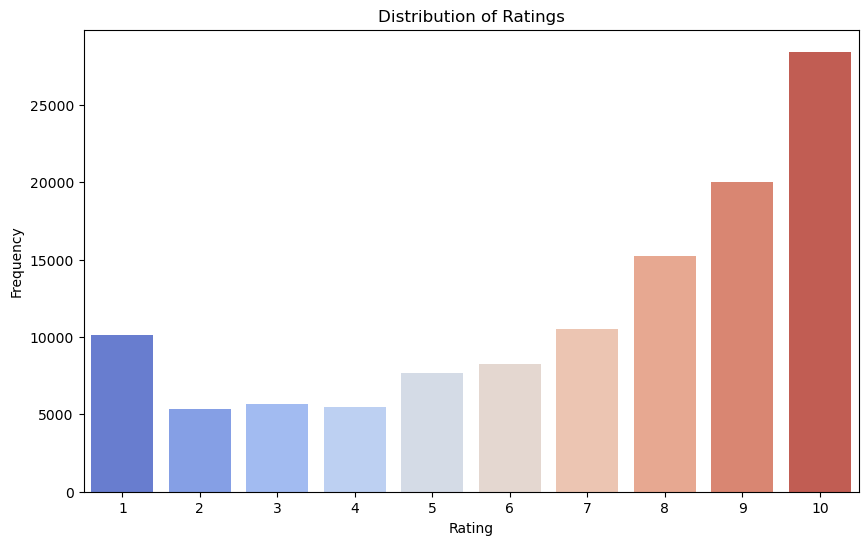

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=data, palette='coolwarm')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

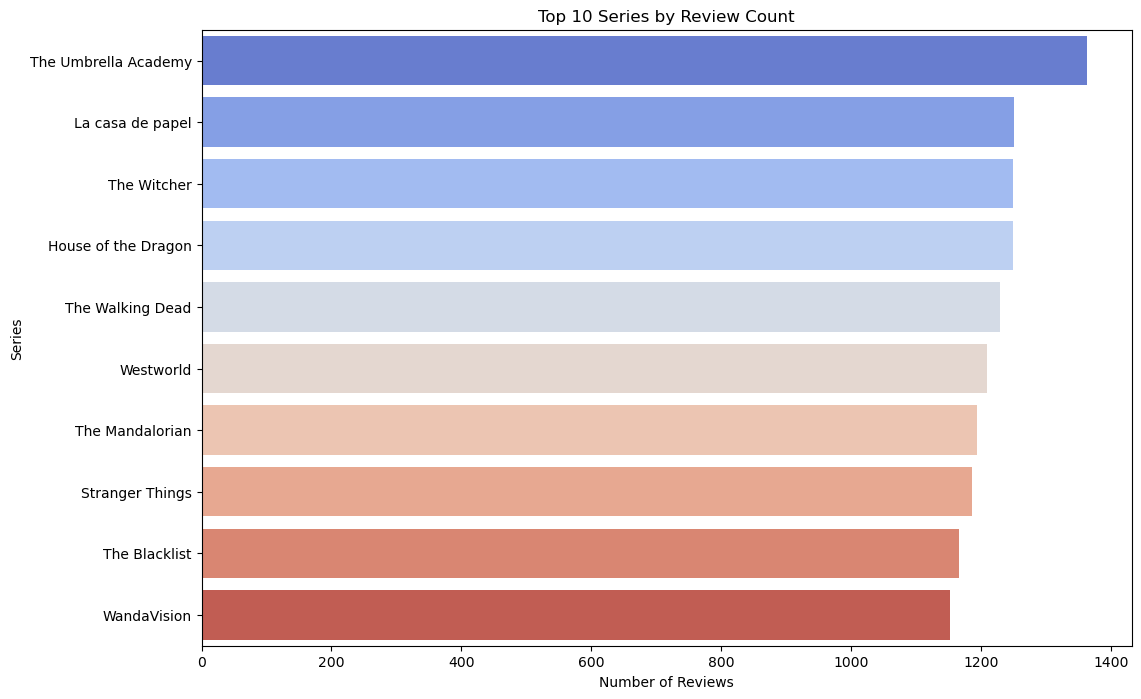

In [9]:
top_series = data['series'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(y=top_series.index, x=top_series.values, palette='coolwarm')
plt.title('Top 10 Series by Review Count')
plt.xlabel('Number of Reviews')
plt.ylabel('Series')
plt.show()

In [10]:
def get_sentiment_score(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a score between -1 (negative) and 1 (positive)

data['sentiment_score'] = data['cleaned_review'].apply(get_sentiment_score)
data['sentiment'] = pd.cut(data['sentiment_score'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

C:\Users\medep\Downloads\Navigator\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


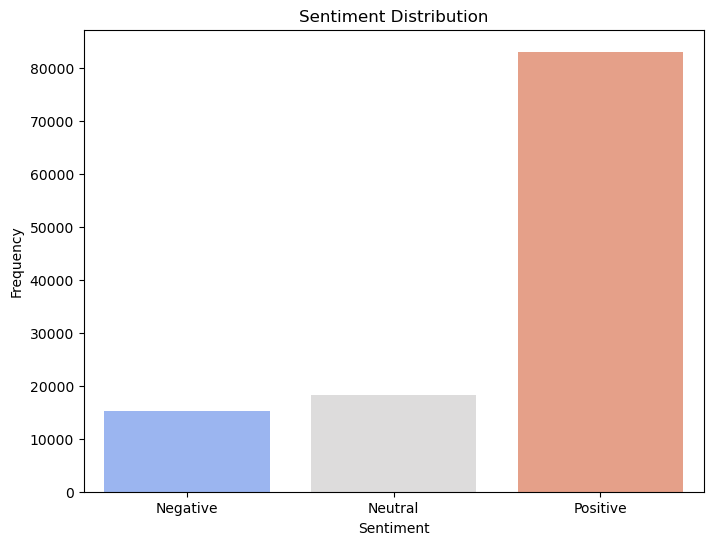

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

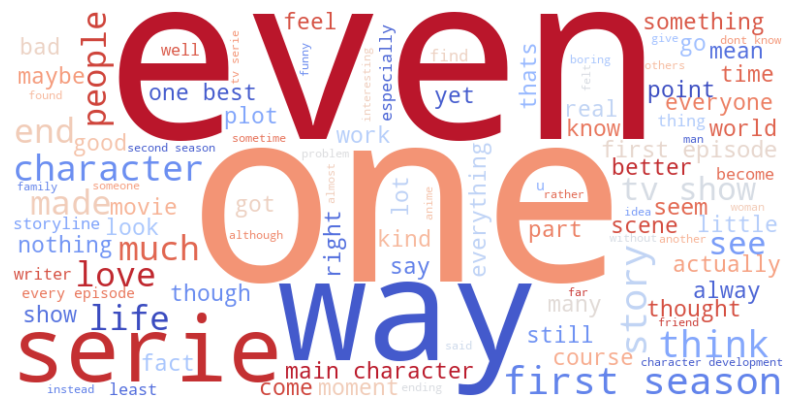

In [12]:
all_words = ' '.join([text for text in data['cleaned_review']])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, colormap='coolwarm').generate(all_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['cleaned_review'])

In [15]:
pca = PCA(n_components=2, random_state=42)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

In [16]:
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_pca)
    score = silhouette_score(tfidf_pca, kmeans.labels_)
    silhouette_scores.append((k, score))

optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]

In [17]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_pca)

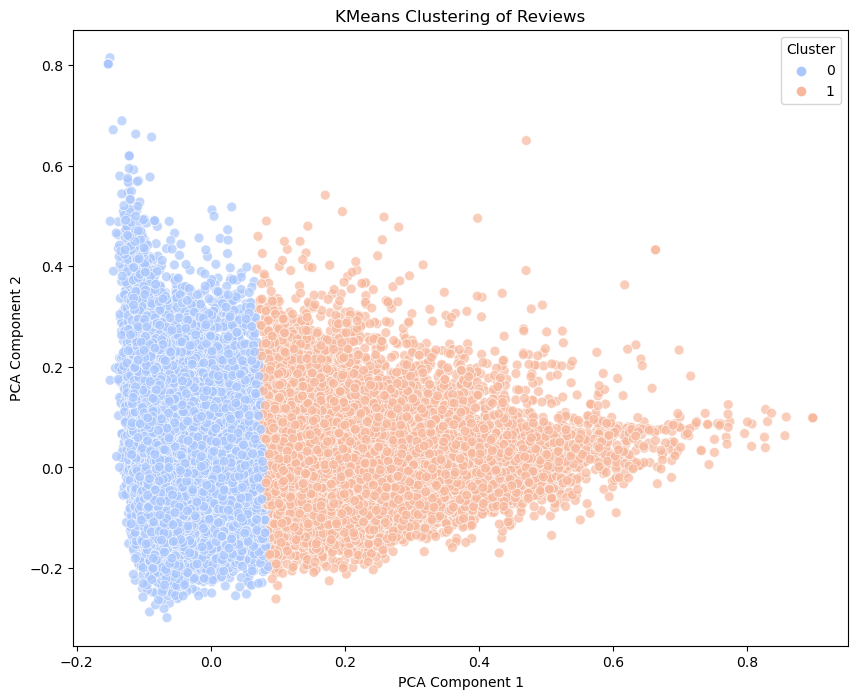

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tfidf_pca[:, 0], y=tfidf_pca[:, 1], hue=data['cluster'], palette='coolwarm', s=50, alpha=0.7)
plt.title('KMeans Clustering of Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [19]:
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [20]:
words = tfidf_vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic #{i + 1}:")
    print(" ".join([words[i] for i in topic.argsort()[-10:]]))

Topic #1:
love episode animation war like best story character series anime
Topic #2:
best good cast episode acting story great season character series
Topic #3:
make time story good episode people series season like character
Topic #4:
character time like watching really watch good series episode season
Topic #5:
good really season watch episode love comedy like character funny


In [21]:
print("\nData Sample with Added Columns:")
print(data[['series', 'rating', 'review', 'sentiment', 'cluster']].head())


Data Sample with Added Columns:
                        series  rating  \
0                        Taboo       9   
1    Star Wars: The Clone Wars       9   
2  How to Get Away with Murder       1   
3                        Suits       2   
4                         Dark       1   

                                              review sentiment  cluster  
0  Dark and mysterious while wonderfully written,...  Positive        1  
1  After many years and a big buildup we have fin...  Positive        1  
2  I don't know if this is deadly accurate of wha...   Neutral        0  
3  A friend of mine is a fan of this show, and en...  Positive        1  
4  Damn this thing moves so slow. Boring characte...  Negative        0  
